In [6]:

api=KaggleApi()
api.authenticate()
os.mkdir("data")
l=["train.csv","test.csv","store.csv"]
for i in l:
    api.competition_download_file("rossmann-store-sales",i,force=True)

ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Mon, 27 Jun 2022 00:39:43 GMT', 'Access-Control-Allow-Credentials': 'true', 'Set-Cookie': 'ka_sessionid=9d67eaf8ff842e3d45146fbb6248caf4; max-age=2626560; path=/, GCLB=CIT985_4lbvGrQE; path=/; HttpOnly', 'Transfer-Encoding': 'chunked', 'Vary': 'Accept-Encoding', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/competitions/data/download/rossmann-store-sales/train.csv', 'X-Kaggle-MillisecondsElapsed': '20', 'X-Kaggle-RequestId': 'edbbe12e0bc0c25b60e3d152a4833953', 'X-Kaggle-ApiVersion': '1.5.12', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-cMvnczQhnXb/MAcE/T2Juw==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://form.jotform.com https://submit.jotform.us https://submit.jotformpro.com https://submit.jotform.com https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kaggle-static-staging.storage.googleapis.com https://kkb-dev.jupyter-proxy.kaggle.net https://kkb-staging.jupyter-proxy.kaggle.net https://kkb-production.jupyter-proxy.kaggle.net https://kkb-dev.firebaseapp.com https://kkb-staging.firebaseapp.com https://kkb-production.firebaseapp.com https://kaggle-metastore-test.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: b'{"code":403,"message":"You must accept this competition\\u0027s rules before you\\u0027ll be able to download files."}'


In [19]:
!pip install inflection

# CLASSES

In [90]:
import dtale, os, atom, shap
#from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
import kaggle
import inflection
from sklearn.pipeline import Pipeline
from functools import wraps
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.core.display import HTML
from IPython.display import Image
pd.options.display.max_columns = 500 # this will set limit of columns to 500
%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\forecast_sales'

In [7]:
class filtrator(BaseEstimator, TransformerMixin):
    def __init__(self,mapper_in=None,mapper_out=None):
        self.mapper_in=mapper_in
        self.mapper_out=mapper_out
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        if self.mapper_in !=None:
            for k,v in self.mapper_in.items():
                X2=X2[X2[k].isin(v)]
        else: pass
        if self.mapper_out !=None:
            for k,v in self.mapper_out.items():
                X2=X2[~X2[k].isin(v)]
        pass
        return X2

In [8]:
class cols_selector(BaseEstimator, TransformerMixin):
    def __init__(self,sel=None,drop=None):
        self.sel=sel
        self.drop=drop
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        if self.sel !=None:
            X2=X.copy()
            X2=X2[self.sel]
        else:
            X2=X.copy()
            X2=X2.drop(self.drop,axis=1)
        return X2

In [9]:
class dtypes(BaseEstimator, TransformerMixin):
    def __init__(self,dict_cols=None):
        self.dict_cols=dict_cols
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        for k,v in self.dict_cols.items():
            X2[k]=X2[k].astype(v)
        return X2

# IMPORT & MERGE

In [27]:
train=pd.read_csv(r"data/train.csv",parse_dates=['Date'])
test=pd.read_csv(r"data/test.csv",parse_dates=['Date'])
store=pd.read_csv("data/store.csv")
train.head(1)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [28]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [37]:
df0=train.merge(store,how='left',on='Store',validate='many_to_one')
assert train.shape[0]==df0.shape[0]
df0.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


# Data Description

In [30]:
df1=df0.copy()
cols_old=df1.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list ( map( snakecase, cols_old))

#rename
df1.columns = cols_new

In [31]:
df1.shape

(1017209, 18)

In [32]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [33]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [48]:
df2['promo_interval'].head()

0                NaN
1    Jan,Apr,Jul,Oct
2    Jan,Apr,Jul,Oct
3                NaN
4                NaN
Name: promo_interval, dtype: object

In [61]:
import math

#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

df1.head()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## Change Types

In [62]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [63]:
for i in ["competition_open_since_month","competition_open_since_year","promo2_since_week","promo2_since_year"]:
    df1[i]=df1[i].astype(int)

Descriptive Statistical

In [64]:
import dtale

In [65]:
dtale.show(df1)

In [77]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
promo2,0.500564,1.0,0.500000,0.0,1.0,-0.002255,-1.999999
is_promo,0.171835,0.0,0.377237,0.0,1.0,1.739838,1.027039


Cat Attributes

In [76]:
cat_cols=df1.select_dtypes(include='object')
cat_cols.nunique()

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

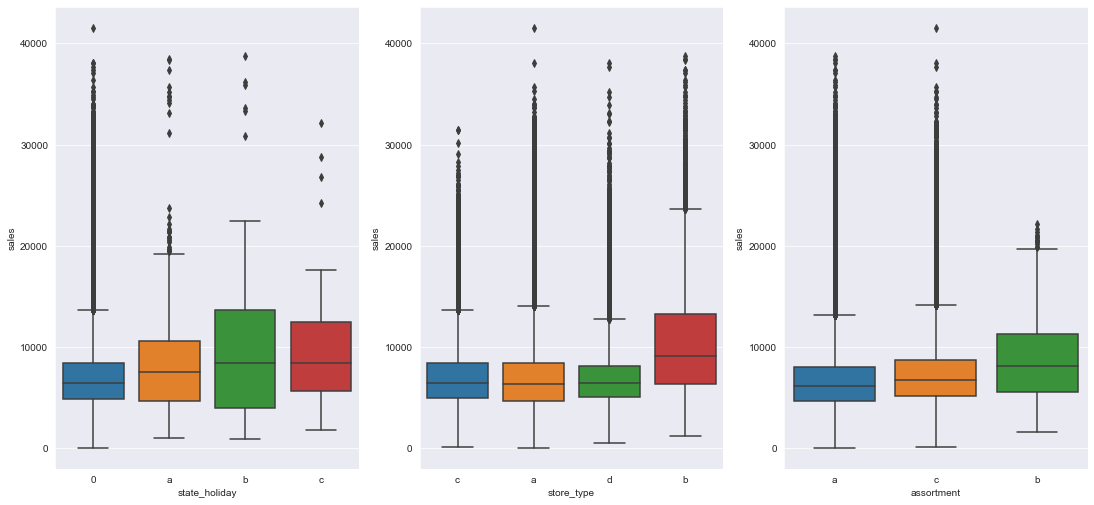

Executing shutdown due to inactivity...


2022-06-27 20:39:27,803 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-06-27 20:39:40,108 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\dtale\app.py", line 410, in shutdown
    shutdown_server()
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\dtale\app.py", line 396, in shutdown_server
    raise RuntimeError("Not running with the Werkzeug Server")
RuntimeError: Not running with the Werkzeug Server


2022-06-27 20:39:40,126 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\flask\app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\dtale\app.py", line 410, in shutdown
    shutdown_server()
  File "p:\Anaconda3\envs\kaggle\lib\site-packages\dtale\app.py", line 396, in shutdown_server
    raise RuntimeError("Not running with the Werkzeug Server")
RuntimeError: Not running with the Werkzeug 

In [89]:
mask1=(df1['state_holiday']!=0) & (df1['sales']>0)
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=df1[mask1],palette='tab10')


fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

# Feature Engineering

In [95]:
os.getcwd()

'p:\\Python\\GitHub\\forecast_sales'

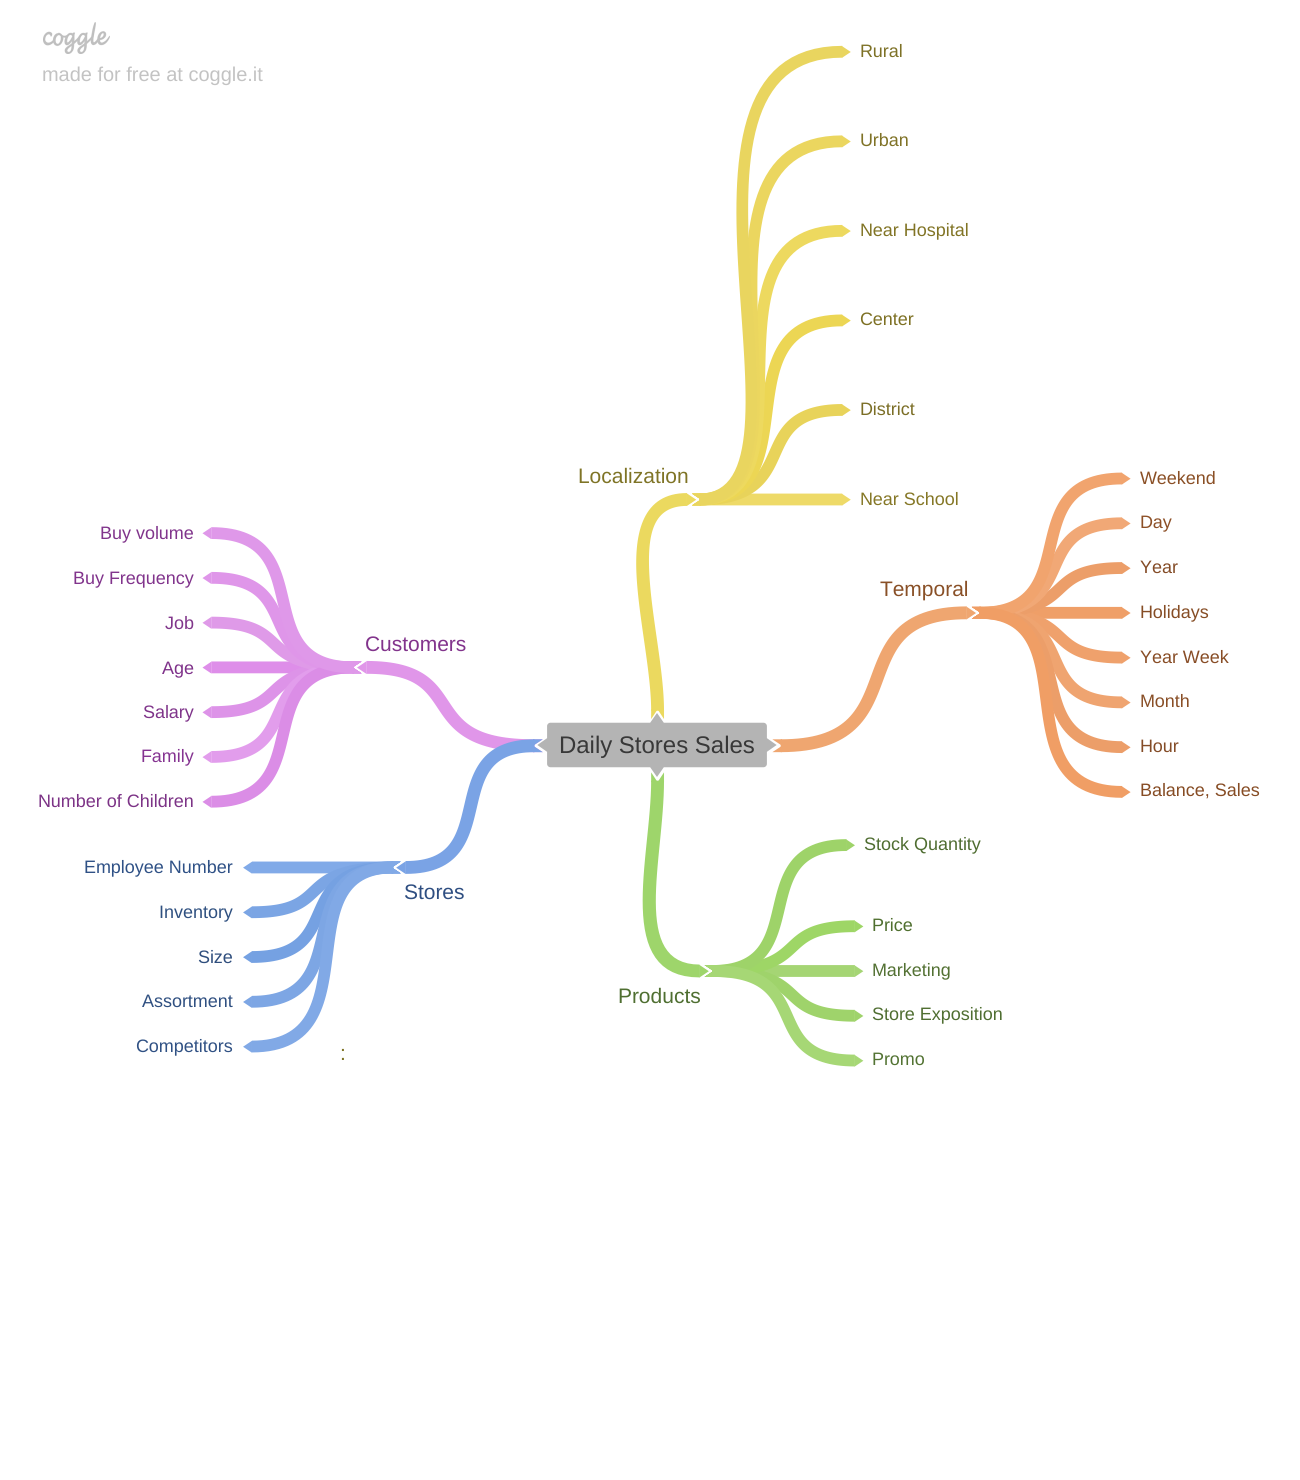

In [96]:
Image('img/Daily_Stores_Sales.png')

# Hypoteshis Creation

### Store Hypoteshsis

In [98]:
df2=df1.copy()

## Feature Engineering

In [99]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day


#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#yeark week
df2['year_week'] = df2['date'].dt.strftime ( '%Y-%W')




#competition since
#promo since

#assortment
#state holiday

In [100]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [43]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [44]:
hol.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [45]:
mask = hol.description=='Viernes Santo'
hol2=hol.copy()
# 'Good Friday' mistake correction
hol2['date'][mask].replace({'2013-04-29': pd.to_datetime('2013-03-29')}, inplace=True)
hol2 = hol2.set_index('date').sort_index()
# keep National level only for simplicity
hol2 = hol2[hol2.locale=='National']
# keep only one event per day
hol2 = hol2.groupby(hol2.index).first().reset_index()
hol2.head()

,date,type,locale,locale_name,description,transferred
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
1,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
3,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
4,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


# Merge with stores, oil and holidays

In [46]:
df0=train.merge(hol2,on='date',how='left').fillna(0).merge(stores,on='store_nbr',validate='many_to_one',how='left')\
.merge(oil,on='date',validate='many_to_one',how='left')\
    
df0=df0.rename(columns={"type_y":"type_holiday","type_x":"type_store"})
assert df0.shape[0]==train.shape[0]
df0.head()


,date,store_nbr,family,sales,onpromotion,type_store,locale,locale_name,description,transferred,city,state,type_holiday,cluster,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN


In [47]:
df0.isnull().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
type_store           0
locale               0
locale_name          0
description          0
transferred          0
city                 0
state                0
type_holiday         0
cluster              0
dcoilwtico      928422
dtype: int64

# VENDAS POR DIA

<AxesSubplot:xlabel='date', ylabel='sales'>

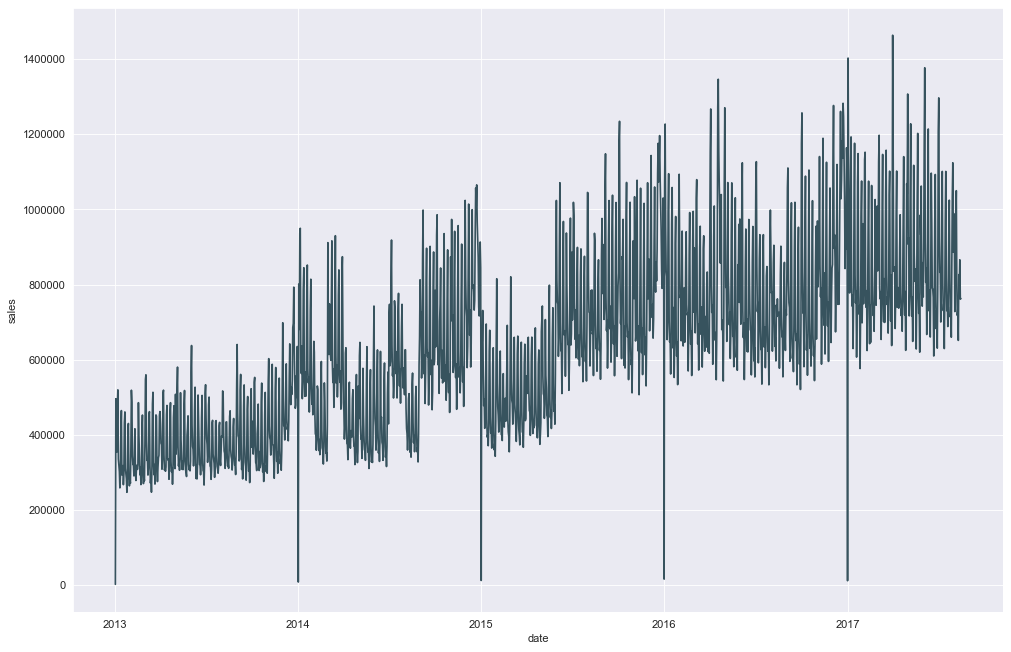

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)

plt.ticklabel_format(style='plain', axis='y')

d=df0.copy()
d=d.groupby(by='date').agg('sum').reset_index()
sns.lineplot(x=d.date,y=d.sales)

# BASELINE

## CONSTRUIR TARGET COM O MÉTODO RECURSIVO - LAG de um dia

In [53]:
full_recursive = []

for source_key, source_key_df in df0.groupby("store_nbr"):
    source_key_df = source_key_df.copy()
    
    source_key_df['Y'] = source_key_df['sales'].shift(-1)
    source_key_df = source_key_df.iloc[:-1]
    
    full_recursive.append(source_key_df)
    
df1 = pd.concat(full_recursive, axis=0, ignore_index=True)

In [58]:
cut_pt='2016-01-01'
train=df1[df1['date']<'2016-01-01']


test=df1[df1['date']>'2016-01-01']


In [59]:
pipe=atom.ATOMRegressor(df1,y='Y',verbose=2,random_state=seed)
pipe.train=train
pipe.test=test

<< ================== ATOM ================== >>
Algorithm task: regression.

Dataset stats ==================== >>
Shape: (3000834, 16)
Memory: 1451.08 MB
Scaled: False
Missing values: 928422 (1.9%)
Categorical features: 9 (60.0%)
Outlier values: 148041 (0.4%)
-------------------------------------
Train set size: 2400668
Test set size: 600166



In [55]:
seed=42
pipe=atom.ATOMRegressor(df1,y='Y',verbose=2,random_state=seed)
pipe.add(cols_selector(drop=['date','state','locale_name',"locale",'description']))
# pipe.add(dtypes(dict_cols={'sex':'object','embarked':'object'}))
#pipe.impute(strat_num='median',strat_cat='most_frequent',max_nan_rows=0.7,verbose=2)
#pipe.scale(strategy='standard')
pipe.impute(strat_num=-1,max_nan_rows=0.7,verbose=2)
pipe.encode(strategy='CatBoost',max_onehot=5,ordinal={'transferred'},verbose=2)
pipe.plot_pipeline()

<< ================== ATOM ================== >>


KeyboardInterrupt: 

In [31]:
pipe.train.head()

,store_nbr,family,sales,onpromotion,city,type_store_A,type_store_B,type_store_C,type_store_D,type_store_E,cluster,dcoilwtico,type_holiday,transferred_False,transferred_True,weekday,month,Y
0,44,270.815757,1305.033,0,556.651781,1.0,0.0,0.0,0.0,0.0,5,-1.00,-1.0,-1.0,-1.0,5,11,791.0
1,42,8.361563,705.394,10,295.954843,0.0,0.0,0.0,1.0,0.0,2,53.90,-1.0,-1.0,-1.0,2,2,6.0
2,11,8.361563,479.000,0,510.367815,0.0,1.0,0.0,0.0,0.0,6,94.28,-1.0,-1.0,-1.0,2,1,0.0
3,21,7.151145,0.000,0,215.122997,0.0,1.0,0.0,0.0,0.0,6,88.73,-1.0,-1.0,-1.0,1,4,0.0
4,1,0.075636,2164.000,10,556.651781,0.0,0.0,0.0,1.0,0.0,13,51.69,-1.0,-1.0,-1.0,3,4,1.0


In [ ]:
df2=full_recursive_df.copy()
df2['weekday'] = df2['date'].dt.weekday
df2['month'] = df2['date'].dt.month
df2.tail()